In [2]:
import pandas as pd  # to store data as dataframe
import numpy as np  # for numerical calculations such as histogramming
import matplotlib.pyplot as plt  # for plotting
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

seed_value = 420  # 42 is the answer to life, the universe and everything
from numpy.random import seed  # import the function to set the random seed in NumPy

seed(seed_value)  # set the seed value for random numbers in NumPy

In [3]:
#v2
h5_file_path = 'DNN_train_data_v2.h5' 

with h5py.File(h5_file_path, 'r') as f:
    p_recon = f['recon'] 
    recons =     np.array([p_recon['nu_EM_px'][:], 
    p_recon['nu_NW_px'][:], 
    p_recon['nu_SN_px'][:], 
    
    p_recon['nu_EM_py'][:], 
    p_recon['nu_NW_py'][:], 
    p_recon['nu_SN_py'][:], 
    
    p_recon['nu_EM_pz'][:], 
    p_recon['nu_NW_pz'][:], 
    p_recon['nu_SN_pz'][:], 
    
    p_recon['nubar_EM_px'][:], 
    p_recon['nubar_NW_px'][:], 
    p_recon['nubar_SN_px'][:], 
    
    p_recon['nubar_EM_py'][:], 
    p_recon['nubar_NW_py'][:], 
    p_recon['nubar_SN_py'][:], 
    
    p_recon['nubar_EM_pz'][:], 
    p_recon['nubar_NW_pz'][:], 
    p_recon['nubar_SN_pz'][:],
        
    p_recon["met_met"][:],
    p_recon["met_phi"][:],
    p_recon["lep_pt_1"][:],
    p_recon["lep_pt_2"][:],
    p_recon["lep_eta_1"][:],
    p_recon["lep_eta_2"][:],
    p_recon["lep_phi_1"][:],
    p_recon["lep_phi_2"][:]    
    
]).T
    
with h5py.File(h5_file_path, 'r') as f:
    p_truth = f['truth'] 
    truths = np.array([
    p_truth['nu_truth_px'][:], p_truth['nu_truth_py'][:], p_truth['nu_truth_pz'][:],
    p_truth['nubar_truth_px'][:], p_truth['nubar_truth_py'][:], p_truth['nubar_truth_pz'][:],
    ]).T




In [4]:
scaler_recons = StandardScaler().fit(recons)
scaled_recons = scaler_recons.transform(recons)
scaler_truths = StandardScaler().fit(truths)
scaled_truths = scaler_truths.transform(truths)

In [5]:
class RegressorDNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressorDNN, self).__init__()
        self.mlp = nn.Sequential(
            nn.LayerNorm(input_size),
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(p=0.01), 
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_size),
        )
    def forward(self, x):
        return self.mlp(x)

In [6]:
class LogCoshLoss(nn.Module):
    def __init__(self):
        super(LogCoshLoss, self).__init__()

    def forward(self, y_pred, y_true):
        loss = torch.log(torch.cosh(y_pred - y_true))
        return torch.mean(loss)

In [7]:
params_tensor = torch.tensor(scaled_recons, dtype=torch.float32)
truth_tensor = torch.tensor(scaled_truths, dtype=torch.float32)

train_size = int(0.9 * len(truths))
val_size = len(truths) - train_size
dataset = TensorDataset(params_tensor, truth_tensor)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Epoch [1/3], Training Loss: 0.6055, Validation Loss: 0.5885
Epoch [2/3], Training Loss: 0.5902, Validation Loss: 0.5843
Epoch [3/3], Training Loss: 0.5875, Validation Loss: 0.5851


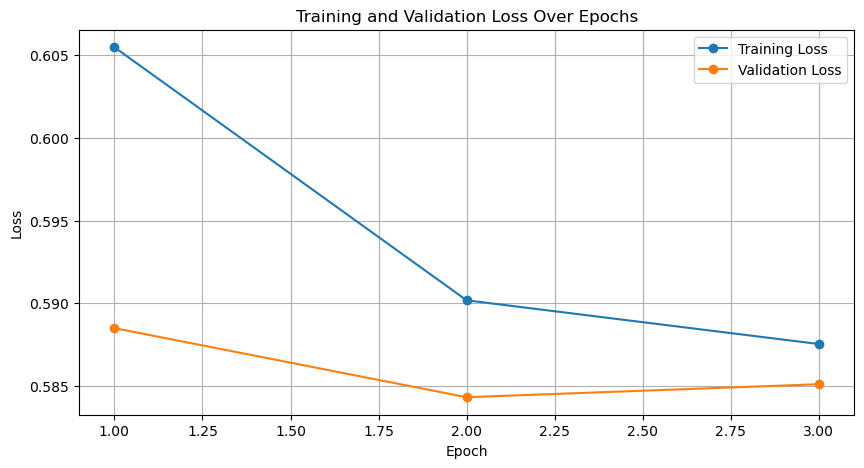

In [9]:

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


model = RegressorDNN(input_size=len(recons[0]), output_size=6)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 3
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train() 
    train_loss = 0
    total_batches = len(trainloader)

    for params_batch, truth_batch in trainloader:
        outputs = model(params_batch)
        loss = criterion(outputs, truth_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= total_batches
    train_losses.append(train_loss)


  # Validation
    model.eval() 
    val_loss = 0
    total_batches = len(val_loader)

    with torch.no_grad():
        for params_batch, truth_batch in val_loader:
            outputs = model(params_batch)
            loss = criterion(outputs, truth_batch)
            val_loss += loss.item()

    val_loss /= total_batches
    val_losses.append(val_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


# Save the trained model
torch.save(model.state_dict(), 'regressor_dnn.pth')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# v2
#look at seeing if values are close for random bits of the test data set unseen by the taining of the DNN

h5_file_path = 'DNN_test_data_v2.h5' 

with h5py.File(h5_file_path, 'r') as f:
    p_recon = f['recon'] 
    recons_test = np.array([
    p_recon['nu_EM_px'][:], 
    p_recon['nu_NW_px'][:], 
    p_recon['nu_SN_px'][:], 
    
    p_recon['nu_EM_py'][:], 
    p_recon['nu_NW_py'][:], 
    p_recon['nu_SN_py'][:], 
    
    p_recon['nu_EM_pz'][:], 
    p_recon['nu_NW_pz'][:], 
    p_recon['nu_SN_pz'][:], 
    
    p_recon['nubar_EM_px'][:], 
    p_recon['nubar_NW_px'][:], 
    p_recon['nubar_SN_px'][:], 
    
    p_recon['nubar_EM_py'][:], 
    p_recon['nubar_NW_py'][:], 
    p_recon['nubar_SN_py'][:], 
    
    p_recon['nubar_EM_pz'][:], 
    p_recon['nubar_NW_pz'][:], 
    p_recon['nubar_SN_pz'][:],
    
    
p_recon["met_met"][:],
p_recon["met_phi"][:],
p_recon["lep_pt_1"][:],
p_recon["lep_pt_2"][:],
p_recon["lep_eta_1"][:],
p_recon["lep_eta_2"][:],
p_recon["lep_phi_1"][:],
p_recon["lep_phi_2"][:]    
]).T
    
with h5py.File(h5_file_path, 'r') as f:
    p_truth = f['truth']  
    truths_test = np.array([
    p_truth['nu_truth_px'][:], p_truth['nu_truth_py'][:], p_truth['nu_truth_pz'][:],
    p_truth['nubar_truth_px'][:], p_truth['nubar_truth_py'][:], p_truth['nubar_truth_pz'][:],
    ]).T


In [11]:
scaled_recons_test = scaler_recons.transform(recons_test)
scaled_truths_test = scaler_truths.transform(truths_test)
params_tensor_test = torch.tensor(scaled_recons_test, dtype=torch.float32)
truth_tensor_test = torch.tensor(scaled_truths_test, dtype=torch.float32)

In [20]:
model.eval()

# Test random data
test_indices = [np.random.choice(len(truths_test), size=1, replace=False)]
test_params = params_tensor_test[test_indices]
test_truth = truth_tensor_test[test_indices]

with torch.no_grad():
    predictions = model(test_params)


print("Predictions (original scale):", scaler_truths.inverse_transform(predictions))
print("Ground Truth (original scale):", scaler_truths.inverse_transform(test_truth))

mse = nn.MSELoss()
test_loss = mse(predictions, test_truth)
print(test_indices)
print(f'Mean Squared Error on test data: {test_loss.item():.4f}')

Predictions (original scale): [[ 8.07584572  6.51710622  8.10439441 22.86890897  2.03791569 26.39694657]]
Ground Truth (original scale): [[  9.92525539 -36.53810844 -85.87385034  56.36178581  30.86760494
   59.99101726]]
[array([129513])]
Mean Squared Error on test data: 0.3152


In [21]:
recons_test[test_indices]

array([[[ 8.1034279e+00, -6.1107380e+01,  8.1034298e+00,  9.5959797e+00,
         -5.8671176e-01,  9.5959787e+00,  1.5233667e+01, -2.4161224e+00,
          1.5233668e+01,  4.6447842e+01,  2.2989056e+01,  4.6447842e+01,
         -8.2872070e-02, -4.0409340e+01, -8.2871348e-02,  8.2980446e+01,
          5.1048570e+00,  8.2980453e+01,  2.3657267e+01,  2.9090977e+00,
          2.3734348e+02,  5.5110378e+01, -4.9473149e-01, -1.0488279e+00,
         -2.2772779e+00,  1.1577996e+00]]], dtype=float32)

In [22]:
#create data output file data 
model.eval()

# Test random data
test_params = params_tensor_test
test_truth = truth_tensor_test
with torch.no_grad():
    predictions = model(test_params)

print("Predictions (original scale):", scaler_truths.inverse_transform(predictions))
print("Ground Truth (original scale):", scaler_truths.inverse_transform(test_truth))

mse = nn.MSELoss()
test_loss = mse(predictions, test_truth)
print(test_indices)
print(f'Mean Squared Error on test data: {test_loss.item():.4f}')
true_predictions = scaler_truths.inverse_transform(predictions)

Predictions (original scale): [[  26.80669952 -145.22790271 -156.50246027    7.52306185    8.16810334
    37.02839849]
 [ -24.61919643   21.83957691   83.94261713  -77.16928384  -51.85331669
   207.31862249]
 [   2.56340411  -58.7416548     4.79266509    1.54350254  -14.21233429
    20.4866222 ]
 ...
 [ -28.66002696  -15.18492672  -19.57477921  -16.18892759    8.64308527
   -14.78250411]
 [   0.4525442   -41.22502473   16.31514892  -23.31449134  -75.06846728
   118.0721966 ]
 [  74.28310607   78.77373196   80.81376488    2.28079848   -8.77106017
  -121.13289705]]
Ground Truth (original scale): [[  22.9682045  -131.82555681 -107.98962217   16.65008325   10.58350929
    27.9789998 ]
 [ -30.1629988     6.35143676   29.140663    -60.07844592  -47.96898478
   145.09655349]
 [ -34.97753436  -64.6802287    -1.16816018   25.88261312  -19.1175386
    -9.9821136 ]
 ...
 [ -45.96736645   23.10713415  180.83434064  -24.78814361  -70.32913482
    64.01767596]
 [ -31.41920611   -7.83020112   71.4997

In [23]:
h5_file = h5py.File("DNN_output_a.h5", 'w')
group2 = h5_file.create_group('DNN')
group2.create_dataset("nu_pt", data=true_predictions[:,0])
group2.create_dataset("nu_phi", data=true_predictions[:,1])
group2.create_dataset("nu_eta", data=true_predictions[:,2])
group2.create_dataset("nubar_pt", data=true_predictions[:,3])
group2.create_dataset("nubar_phi", data=true_predictions[:,4])
group2.create_dataset("nubar_eta", data=true_predictions[:,5])
h5_file.close()